In [1]:
import os
import sys

# JAX
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# Matplotlib
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 15

# Internal modules
current_file_dir = os.getcwd()
module_path = os.path.abspath(os.path.join(current_file_dir, ".."))
sys.path.append(module_path)
from diffPLOG2TROE.falloff import kinetic_constant_falloff
from diffPLOG2TROE.cabr import kinetic_constant_cabr
from diffPLOG2TROE.pressure_logarithmic import kinetic_constant_plog, compute_plog

# Fall Off
Hereinafter it is shown how to compute the kinetic constant for a Fall-Off reaction adopting different formalisms for the fitting of the pressure dependent broadening factor. The following example is taken from the CHEMKIN manual.

```
CH3 + CH3 (+M) = C2H6 (+M)   6.220E+16  -1.174  635.80
 LOW/    1.135E+36  -5.246  1704.8      /
TROE/    0.405  1120.  69.6  0.000      /
```

In [2]:
# Internal representation of the formalism

falloff_troe = (
    jnp.array([
        [3.690e+24, -2.230000, 8.807e+4, 0.000],  # HPL, the fourth term is dummy
        [1.782e+60, -1.228e+1, 8.398e+4, 0.000],  # LPL, the fourth term is dummy
        [2.3520e-1, 7.2400e+2, 5.000e+9, 5.0e+9],  # TROE parameters
    ], dtype=jnp.float64),
    1, # Lindemann -> 0, TROE -> 1, SRI -> 2
)

falloff_lindemann = (
    jnp.array([
        [3.690e+24, -2.230000, 8.807e+4, 0.000],  # HPL, the fourth term is dummy
        [1.782e+60, -1.228e+1, 8.398e+4, 0.000],  # LPL, the fourth term is dummy
    ]),
    0, # Lindemann -> 0, TROE -> 1, SRI -> 2
)

In [3]:
kc = []
k0 = []
kInf = []
M = []
kcl = []

T = jnp.float64(1000.)
P = jnp.logspace(-5, 2, 300, dtype=jnp.float64)
for p in P:
    _kc, _k0, _kInf, _M = kinetic_constant_falloff(falloff_troe, 1000., p)
    kc.append(_kc)
    k0.append(_k0 * _M)
    kInf.append(_kInf)
    M.append(_M)

    _kcl, _, _, _ = kinetic_constant_falloff(falloff_lindemann, 1000., p)
    kcl.append(_kcl)

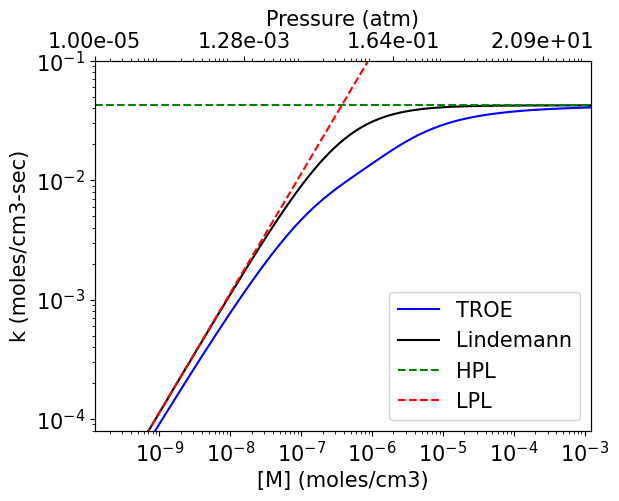

In [4]:
fig, ax = plt.subplots()

# Main plot
ax.plot(M, kc, "b-", label="TROE")
ax.plot(M, kcl, "k-", label="Lindemann")
ax.plot(M, kInf, "g--", label="HPL")
ax.plot(M, k0, "r--", label="LPL")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([min(M), max(M)])
ax.set_ylim([8e-5, 1e-1])
ax.set_xlabel("[M] (moles/cm3)")
ax.set_ylabel("k (moles/cm3-sec)")
ax.legend(loc="lower right")

# Create a secondary x-axis on top that shows pressure values (P)
ax_top = ax.twiny()
# Set the same x-limits for the secondary axis based on M
ax_top.set_xlim(ax.get_xlim())
# Set the secondary axis to log scale
ax_top.set_xscale('log')
# Set the new ticks and labels for the secondary axis based on P
# Here, we're assuming P corresponds to M in a one-to-one relationship from your loop
ax_top.set_xticks(M[::90])  # Choose appropriate intervals
ax_top.set_xticklabels([f"{p:.2e}" for p in P[::90]])  # Format P values as scientific notation

# Label for the secondary x-axis
ax_top.set_xlabel("Pressure (atm)")
plt.show()

# Chemically activated bimolecular reactions (CABR)
Hereinafter it is shown how to compute the kinetic constant for a CABR reaction adopting different formalisms for the fitting of the pressure dependent broadening factor. The following example is taken from the CHEMKIN manual.

```
CH3 + CH3 (+M) = C2H5 + H (+M)    4.9890E+12 9.9000E-02 1.060E+04
 HIGH /    3.8000E-07   4.8380E+00    7.710E+03 /
SRI   /    1.641  4334  2725  1.0  .0           /
```

In [5]:
# Internal representation of the formalism

cabr_sri = (
    jnp.array([
        [4.9890E+12, 9.9000E-02, 1.060E+04, .0, .0],  # LPL, the fourth and fifth terms are dummy
        [3.8000E-07, 4.8380E+00, 7.710E+03, .0, .0],  # HPL, the fourth and fifth terms are dummy
        [1.641, 4334, 2725, 1., .0] # The original formulation is with d = 1 and e = 0, here we support the 5 parameters formulation 
    ], dtype=jnp.float64),
    2, # Lindemann -> 0, TROE -> 1, SRI -> 2
)

cabr_lindemann = (
    jnp.array([
        [4.9890E+12, 9.9000E-02, 1.060E+04, .0], # LPL, the fourth term is dummy
        [3.8000E-07, 4.8380E+00, 7.710E+03, .0],   # HPL, the fourth term is dummy
    ], dtype=jnp.float64),
    0, # Lindemann -> 0, TROE -> 1, SRI -> 2
)

In [6]:
kc = []
k0 = []
kInf = []
M = []
kcl = []

T = jnp.float64(1000)
P = jnp.logspace(-2, 5, 300)

for p in P:
    _kc, _k0, _kInf, _M = kinetic_constant_cabr(cabr_sri, T, p)
    kc.append(_kc)
    k0.append(_k0)
    kInf.append(_kInf / _M)
    M.append(_M)

    _kcl, _, _, _ = kinetic_constant_cabr(cabr_lindemann, T, p)
    kcl.append(_kcl)

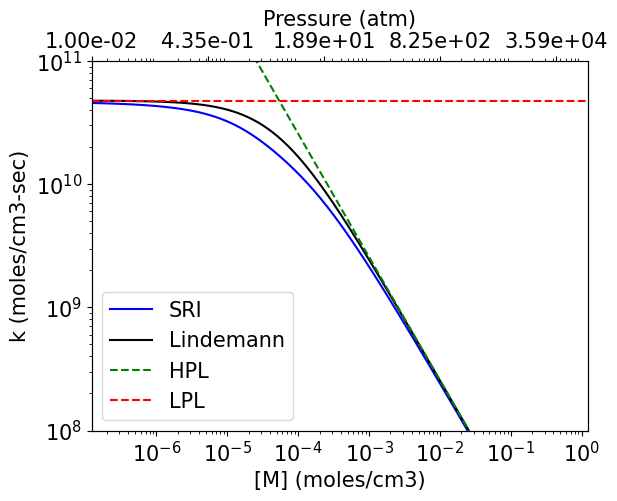

In [7]:
fig, ax = plt.subplots()
ax.plot(M, kc, 'b-', label="SRI")
ax.plot(M, kcl, 'k-', label="Lindemann")
ax.plot(M, kInf, "g--", label="HPL")
ax.plot(M, k0, "r--", label="LPL")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlim([min(M), max(M)])
plt.ylim([1e8, 1e11])
ax.set_xlabel("[M] (moles/cm3)")
ax.set_ylabel("k (moles/cm3-sec)")
ax.legend(loc="lower left")

ax_top = ax.twiny()
ax_top.set_xlim(ax.get_xlim())
ax_top.set_xscale('log')
ax_top.set_xticks(M[::70])
ax_top.set_xticklabels([f'{p:.2e}' for p in P[::70]])
ax_top.set_xlabel("Pressure (atm)")
plt.show()

# Pressure Logarithmic Rate expression (PLOG)
Hereinafter it is shown how to compute the kinetic constant for a PLOG reaction. The following example is taken from the CRECK kinetic model. The second example shows how to compute the constant in a vectorized way over a range of pressures and temperatures, keep in mind that this capability is available also for the FallOff and the CABR formulation.

```
HOCO=H+CO2               1.8970e+38      -8.047         34240.00
 PLOG /  1.000000e-03    4.758000e+18    -3.817000e+00   1.767600e+04    /
 PLOG /  3.000000e-03    2.225000e+20    -4.149000e+00   1.903700e+04    /
 PLOG /  9.900000e-03    7.564000e+21    -4.434000e+00   2.032500e+04    /
 PLOG /  2.960000e-02    9.107000e+24    -5.189000e+00   2.241900e+04    /
 PLOG /  9.870000e-02    3.144000e+29    -6.376000e+00   2.523300e+04    /
 PLOG /  2.961000e-01    1.150000e+32    -7.037000e+00   2.666200e+04    /
 PLOG /  9.869000e-01    1.069000e+36    -8.107000e+00   2.906400e+04    /
 PLOG /  2.960700e+00    2.438000e+36    -8.153000e+00   2.933600e+04    /
 PLOG /  9.869000e+00    6.663000e+35    -7.919000e+00   2.921700e+04    /
 PLOG /  2.960700e+01    1.723000e+38    -8.506000e+00   3.127300e+04    /
 PLOG /  9.869000e+01    3.007000e+41    -9.290000e+00   3.396600e+04    /
 PLOG /  2.960700e+02    6.767000e+36    -7.832000e+00   3.161300e+04    /
 PLOG /  9.869000e+02    1.897000e+38    -8.047000e+00   3.424000e+04    /
```

In [8]:
plog_constant = jnp.array([
    [1.000000e-03, 4.758000e+18, -3.817000e+00, 1.767600e+04],
    [3.000000e-03, 2.225000e+20, -4.149000e+00, 1.903700e+04],
    [9.900000e-03, 7.564000e+21, -4.434000e+00, 2.032500e+04],
    [2.960000e-02, 9.107000e+24, -5.189000e+00, 2.241900e+04],
    [9.870000e-02, 3.144000e+29, -6.376000e+00, 2.523300e+04],
    [2.961000e-01, 1.150000e+32, -7.037000e+00, 2.666200e+04],
    [9.869000e-01, 1.069000e+36, -8.107000e+00, 2.906400e+04],
    [2.960700e+00, 2.438000e+36, -8.153000e+00, 2.933600e+04],
    [9.869000e+00, 6.663000e+35, -7.919000e+00, 2.921700e+04],
    [2.960700e+01, 1.723000e+38, -8.506000e+00, 3.127300e+04],
    [9.869000e+01, 3.007000e+41, -9.290000e+00, 3.396600e+04],
    [2.960700e+02, 6.767000e+36, -7.832000e+00, 3.161300e+04],
    [9.869000e+02, 1.897000e+38, -8.047000e+00, 3.424000e+04],
], dtype=jnp.float64)

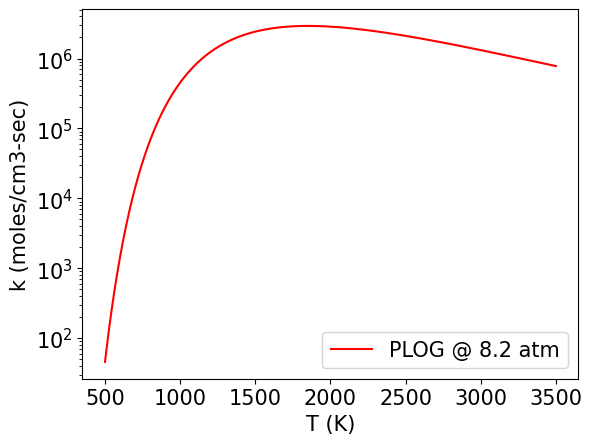

In [9]:
T = jnp.linspace(500, 3500, 300, dtype=jnp.float64)
P = jnp.float64(8.2)

kc = []
for t in T:
    _kc = kinetic_constant_plog(plog_constant, t, P)
    kc.append(_kc)

plt.plot(T, kc, "r-", label=f"PLOG @ 8.2 atm")
plt.yscale("log")
plt.xlabel("T (K)")
plt.ylabel("k (moles/cm3-sec)")
plt.legend()
plt.show()

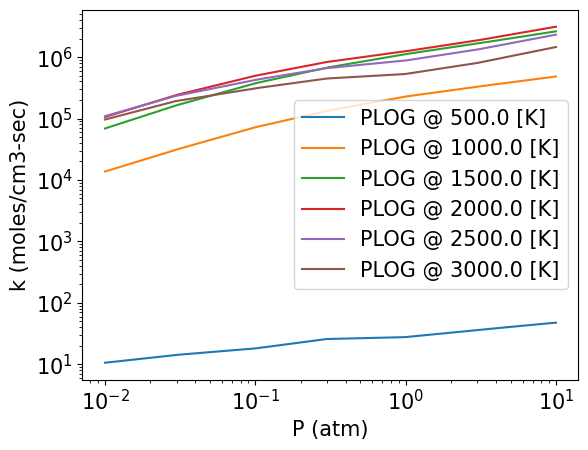

In [10]:
T = jnp.array([500, 1000, 1500, 2000, 2500, 3000], dtype=jnp.float64)  # Obv these are dummy values :)
P = jnp.logspace(-2, 1 , 300, dtype=jnp.float64)

for t in T:
    kc = compute_plog(plog_constant, jnp.array([t]), P)
    plt.plot(P, kc, "-", label=f"PLOG @ {t} [K]")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("P (atm)")
plt.ylabel("k (moles/cm3-sec)")
plt.legend()
plt.show()